# Introduction to Random Forests

### Business case:

The goal of this exercise can be found here https://www.kaggle.com/c/bluebook-for-bulldozers#description

TL;DR: 
The goal is **to predict the sale price** of a particular piece of heavy equiment at auction **based on the 3 following parameters**: 
- **its usage**
- **the equipment type**
- **its configuration**

The data is sourced from auction result postings and includes information on usage and equipment configurations.

Helpful URLs:
- 1- Problem description: https://www.kaggle.com/c/bluebook-for-bulldozers#description
- 2- Evaluation of our results: https://www.kaggle.com/c/bluebook-for-bulldozers#evaluation
- 3- Download link of the dataset: https://www.kaggle.com/c/bluebook-for-bulldozers/data

### Dev environment setup:

The courses use the deprecated version 0.7 of the FastAI lib, so installing fastai through `conda` or `pip` will install by default the `version 1` of the lib and will make the code of the course not working. (because of changed imports)

Below are what we would use to create a fastai v0.7 conda environment.

### Jupyter notebook configuration

In [1]:
# The following 2 lines will allow the notebook to listen to modules 
# changes and applying them without needing to restart the kernel.
%load_ext autoreload
%autoreload 2

# The following line is to show plots within the notebook
%matplotlib inline

### 1- Python Imports 
We still don't know what we need, so let's import everything we might use.

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

### 2- Dataset folder path
Create a directory on the root of your project, `datasets/Bluebook_for_bulldozers/`, this is where we'll download and put our data sets.

In [3]:
dataset_path = 'datasets/Bluebook_for_bulldozers/'

In [4]:
# Let's verify its content
# by prefixing an instruction by "!" we tell jupyter what's next is a Bash command.
# the "{}" allow us to template our bash command with a Python variable (dataset_path in our case) 
!ls {dataset_path}

README.txt     test.csv       training.csv   validation.csv


In [5]:
# Let's print the content of README.txt
!cat {dataset_path}/README.txt

This dataset comes from:
https://www.kaggle.com/c/bluebook-for-bulldozers/data

The DataSet is structured as CSV files and is split in 3 parts:
    - Training Set: Train.zip, extracted as "training.csv"
    - Validation Set: Valid.zip, extracted as "validation.csv"
    - Test Set: Test.zip, extracted as "test.csv"

### 3- Look at the data:
Now, we need to look at our data, to know what we're dealing with, such as the types and formats of the columns etc.

In [6]:
# Our dataset is organised as a CSV file, pandas offers a function read_csv to parse CSV files.
df_raw = pd.read_csv('{}training.csv'.format(dataset_path), low_memory=False)

In [7]:
# Let's look at the first 3 rows
df_raw.head(3)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# 53 Columns is a lot to be displayed on a line, we see that Jupyter truncates many columns
# Let's transpose the data matrix to display the columns as rows
df_raw.transpose()

,0,1,2,3,4,5,6,7,8,9,...,401115,401116,401117,401118,401119,401120,401121,401122,401123,401124
SalesID,1139246,1139248,1139249,1139251,1139253,1139255,1139256,1139261,1139272,1139275,...,6333290,6333302,6333307,6333311,6333335,6333336,6333337,6333338,6333341,6333342
SalePrice,66000,57000,10000,38500,11000,26500,21000,27000,21500,65000,...,10000,8500,10000,9500,8500,10500,11000,11500,9000,7750
MachineID,999089,117657,434808,1026470,1057373,1001274,772701,902002,1036251,1016474,...,1843374,1825337,1821747,1828862,1798293,1840702,1830472,1887659,1903570,1926965
ModelID,3157,77,7009,332,17311,4605,1937,3539,36003,3883,...,21437,21437,21437,21437,21435,21439,21439,21439,21435,21435
datasource,121,121,121,121,121,121,121,121,121,121,...,149,149,149,149,149,149,149,149,149,149
auctioneerID,3,3,3,3,3,3,3,3,3,3,...,2,2,2,2,2,1,1,1,2,2
YearMade,2004,1996,2001,2001,2007,2004,1993,2001,2008,1000,...,2005,2005,2005,2006,2005,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,68,4640,2838,3486,722,508,11540,4883,302,20700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UsageBand,Low,Low,High,High,Medium,Low,High,High,Low,Medium,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,11/16/2006 0:00,3/26/2004 0:00,2/26/2004 0:00,5/19/2011 0:00,7/23/2009 0:00,12/18/2008 0:00,8/26/2004 0:00,11/17/2005 0:00,8/27/2009 0:00,8/9/2007 0:00,...,10/25/2011 0:00,10/25/2011 0:00,10/25/2011 0:00,10/25/2011 0:00,10/25/2011 0:00,11/2/2011 0:00,11/2/2011 0:00,11/2/2011 0:00,10/25/2011 0:00,10/25/2011 0:00


### 4- Set the types not infered by default:
Pandas infers the types automatically by default, we however need to specify that certain columns are neither strings nor numerical values, such as dates. 
We will then use a well formated dataframe.

In [9]:
# We use parse_dates to specify the columns that are of date types.
df_raw = pd.read_csv('{}training.csv'.format(dataset_path), 
                    low_memory=False, 
                    parse_dates=['saledate'])

### 5- Evaluation metric:
We need to specify what would be the evaluation metric used to define the correctness of our predictions.
In our case, the problem asks us to use RMSLE (root mean squared log error) between the actual and predicted auction prices. (see the evaluation metrics url on the top of this notebook)

Which means, our end goal is to minimize the value of: 

`√(∑(log(actual_price) - log(predicted_price))² / number_of_records)`

Which means, we will focus on the `log` as well, and replace the actual price column of our data set to its log.

We'll use `numpy` for this, which is a library for math operations.

In [10]:
# Here are the 2 ways with which we can retrieve a column from a numpy dataframe
df_raw['SalePrice']
# or, on Jupyter notebooks
df_raw.SalePrice

0         66000
1         57000
2         10000
3         38500
4         11000
5         26500
6         21000
7         27000
8         21500
9         65000
10        24000
11        22500
12        36000
13        30500
14        28000
15        19000
16        13500
17         9500
18        12500
19        11500
20        41000
21        34500
22        26000
23        73000
24        33000
25        12500
26        15500
27        53000
28        46000
29        89000
          ...  
401095    10500
401096    10000
401097     8500
401098    10500
401099    11000
401100    10500
401101    10000
401102    10500
401103    12500
401104    10500
401105    10000
401106    10500
401107    12500
401108    10500
401109    10500
401110    10500
401111    10000
401112    10500
401113    10500
401114    12500
401115    10000
401116     8500
401117    10000
401118     9500
401119     8500
401120    10500
401121    11000
401122    11500
401123     9000
401124     7750
Name: SalePrice, Length:

In [11]:
# Now let's replace the 'SalePrice' column values with their log
df_raw['SalePrice'] = np.log(df_raw['SalePrice'])

# Let's take the 3 first elements to take a look at the new values
df_raw['SalePrice'].head(3)

0    11.097410
1    10.950807
2     9.210340
Name: SalePrice, dtype: float64

### 6- Initial Processing
We will use Random Forest which is a powerful machine learning algorithm used on Regression problems (predicting continuous numerical values such as the price of a property) and on Classification problems (predicting labels / discrete values, such as whether an email is a spam or not).

Given our goal in this exercise is to predict the sale price of an equipment, we will use a Regressor, more specifically, the `RandomForestRegressor` class of the `sklearn` library.

In [12]:
# We create a RandomForestRegressor
# We'll set the value of the n_jobs argument at -1, in order to use all the processors and speed up the prediction.
regressor = RandomForestRegressor(n_jobs=-1) 

We know want to fit our training data set to the regressor in order to train our model. 

We want to put all the columns as input data, and exclude the `SalePrice` column which is the output. In other words, we want to have a list of data with which we want to predict the `SalePrice`.

One important thing to note is that machine learning alogorithms only process numerical values, however our dataset contains `strings` and other types that are not numerical, this is why we'll have to convert these columns into numerical ones.

In [13]:
# Let's take care of extracting all the might-be useful infos from the saledate column, then drop saledate
add_datepart(df_raw, 'saledate')

# Let's see what new columns we got by doing so
df_raw.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',


In [14]:
# Now let's take care of our categorical variables (strings)
train_cats(df_raw)

# Now our categorical variables become of type 'category'.
# We will then be able to read the category number with category.code

In [15]:
# We could also set an order on which we wish to numerically encode a cat data
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

### 7- Saving our progress made on the dataframe 
We are not quite done yet, but let's just, as a rule of thumb, save our dataframe after all the processing we made on it.

In [16]:
backup_path = './tmp/data/Bluebook-for-buldozers/'
os.makedirs(backup_path, exist_ok=True)
df_raw.to_feather('{}training-raw'.format(backup_path))

Now let's import it back:

In [17]:
df_raw = pd.read_feather('{}training-raw'.format(backup_path))

/Users/mehdi/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


### 8- Handling missing values and categorical variables:

We'll replace categories (`string` values) with their numerical codes, handle missing continuous values (`n/a`) by replacing them with the median of the column. Pandas automatically handles missing categorical variables by replacing them by `-1`. 
Then, we will split the dependent variable `SalePrice` (the output variable predicted by the "dependant" variables or input variables) into a separate variable `y`.

In [18]:
# The following splits the data, + turning categories with their mapped numericals code
# The split is giving us 3 variables:
# df: independant variables numerically encoded, y: dependant variable, 
# nas: columns telling us if the respected record was null
df, y, nas = proc_df(df_raw, 'SalePrice')

### 9- Running random forest on the training set: (training our model)
We can now use Random Forest to train our model on our training data and make the prediction with this cleaned and normalised training dataframe.

In [19]:
# We fit the independant variables (df) and dependant variable (y) to our regressor
regressor.fit(df, y)

/Users/mehdi/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

We now will see the r-squared score of our prediction.
**Note:** In statistics, the coefficient of determination, denoted R2 or r2 and pronounced "R squared", is the proportion of the variance in the dependent variable that is predictable from the independent variable(s). https://en.wikipedia.org/wiki/Coefficient_of_determination

if r^2 == 1, means that we have done well. As opposed to a value of 0 which means our prediction performed badly (predicted the mean), or worse if negative.

In [20]:
regressor.score(df, y)

0.9832514726917223

### 10- Interpreting first results

Our score is 0.98, which is very close to 1, BUT, this could mean that our prediction model only performs well on our training data but might not generalize.
We call this **Overfitting** (high variance). Meaning that our models performs almost perfectly on our training set but would fail in production using a different data set.

**Underfitting** (high bias) is the opposite phenomenon, on which our model doesn't perform well even on our training data.

What we want is the right middle, a model good enough for our training data and good enough for different data.

Which is why it's important to split our data into 3 different sets: training set, validation set, test set.

Note: On a problem on which we have the time element as part of the set, we want to have the training set in a certain period of time, validation set in a different period of time, and test set in another different period.

Luckily in our problem, the data is already sorted by date.

In [21]:
# we declare a function that splits a dataframe into 2 different 
# new sets with the index depending on the length argument
def split_vals(data_frame, length): 
    return data_frame[:length].copy(), data_frame[length:].copy()

n_validation = 12000  # same as Kaggle's test set size
n_training = len(df) - n_validation

X_train, X_valid = split_vals(df, n_training) # independant vars of training and validations sets
y_train, y_valid = split_vals(y, n_training)  # dependant vars of training and validations sets

X_train.shape, y_train.shape, X_valid.shape # prints the dimensions of a Pandas DataFrame

((389125, 66), (389125,), (12000, 66))

### 11- Using the Validation Set:

Now, let's test our model using the validation set previously created.

We first create 2 utility methods:

In [22]:
# Root mean squared error
def rmse(prediction_value, actual_value): 
    return math.sqrt(((prediction_value - actual_value) ** 2).mean())

def print_score(regressor):
    res = {
        'training_set_rmse': rmse(regressor.predict(X_train), y_train), 
        'validation_set_rmse': rmse(regressor.predict(X_valid), y_valid),
        'training_set_rsquared': regressor.score(X_train, y_train), 
        'validation_set_rsquared': regressor.score(X_valid, y_valid)}
    
    if hasattr(regressor, 'oob_score_'): 
        res['oob_score_'] = regressor.oob_score_
        
    print(res)

We know proceed to training the model on the training set and calculating the score of our predictions

In [23]:
regressor = RandomForestRegressor(n_jobs=-1)

%time regressor.fit(X_train, y_train) # should also show us the time spent on the training

print_score(regressor)

/Users/mehdi/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 1min 32s, sys: 809 ms, total: 1min 33s
Wall time: 18.7 s
{'training_set_rmse': 0.09063999071240875, 'validation_set_rmse': 0.2524547995837613, 'training_set_rsquared': 0.9828298325416853, 'validation_set_rsquared': 0.886180876327556}


We see that our model overfits, given the fact that the `validation_set_rmse` is quite large.

Let's try to understand this using a visual representation.

### 12- Speeding up the training

It's painful to having to wait more than 10sec for our model to be trained, on an interactive coding/machine learning session or data analysis, like our current notebook, let's reduce the training set size for this.

In [25]:
# Let's reduce the size of the Training Set to 30000
df_train, y_train, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)

# Let's split our data set, we don't need the validation set, so we throw the result into "_"
X_train, _ = split_vals(df_train, 20000) 
y_train, _ = split_vals(y_train, 20000)

Now let's train a new model on the reduced training set:

In [28]:
regressor = RandomForestRegressor(n_jobs=-1)
%time regressor.fit(X_train, y_train)
print_score(regressor)

/Users/mehdi/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 3.14 s, sys: 32.6 ms, total: 3.18 s
Wall time: 713 ms
{'training_set_rmse': 0.11129129162601276, 'validation_set_rmse': 0.3806419673144572, 'training_set_rsquared': 0.9729591773172587, 'validation_set_rsquared': 0.7412494315251048}


Note: We see that our model performs very badly.

### 13- Visualizing the Random forest
A random forest is a group (ensemble) of multiple trees, called `estimators` on the scikit-learn library.
To make our visualisation easy, let's build a random forest of only 1 tree and with a small depth.

In [29]:
regressor = RandomForestRegressor(n_jobs=-1, max_depth=3, n_estimators=1, bootstrap=False)
%time regressor.fit(X_train, y_train)
print_score(regressor)

CPU times: user 155 ms, sys: 11.3 ms, total: 166 ms
Wall time: 196 ms
{'training_set_rmse': 0.521746568711654, 'validation_set_rmse': 0.5827684210736772, 'training_set_rsquared': 0.4056849365997228, 'validation_set_rsquared': 0.3934871667740283}


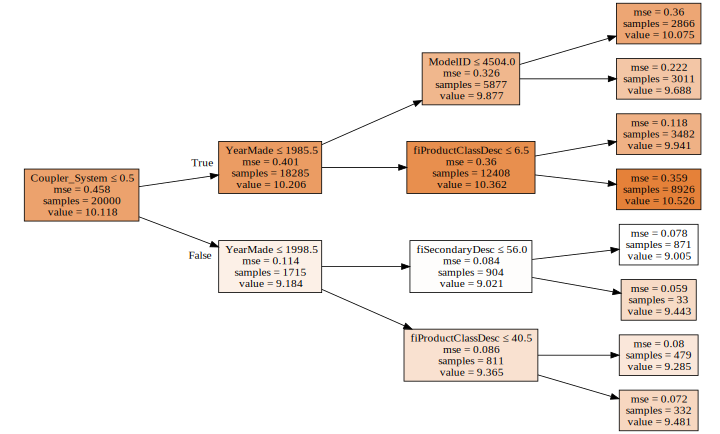

In [30]:
draw_tree(regressor.estimators_[0], df_train, precision=3)

We basically either stop the splitting when reaching the `max_depth` parameter, or ideally when each split node at the end only has 1 element each (we call the latest nodes, leaf nodes).